In [7]:
# imports
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
from torch.utils.data import Dataset

In [5]:
# define network

# pytorch class defining a 3D Unet with skip connections
class UNet3D(nn.Module):
    def __init__(self):
        super(UNet3D, self).__init__()

        self.conv1 = self.conv_block(1, 16)
        self.conv2 = self.conv_block(16, 32)
        self.conv3 = self.conv_block(32, 64)
        self.conv4 = self.conv_block(64, 128)

        self.upconv5 = self.upconv_block(128, 64)
        self.conv5 = self.conv_block(128, 64)

        self.upconv6 = self.upconv_block(64, 32)
        self.conv6 = self.conv_block(64, 32)

        self.upconv7 = self.upconv_block(32, 16)
        self.conv7 = self.conv_block(32, 16)

        self.conv8 = nn.Conv3d(16, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        conv1 = self.conv1(x)
        pool1 = nn.functional.max_pool3d(conv1, kernel_size=2, stride=2)

        conv2 = self.conv2(pool1)
        pool2 = nn.functional.max_pool3d(conv2, kernel_size=2, stride=2)

        conv3 = self.conv3(pool2)
        pool3 = nn.functional.max_pool3d(conv3, kernel_size=2, stride=2)

        conv4 = self.conv4(pool3)

        up5 = torch.cat([self.upconv5(conv4), conv3], dim=1)
        conv5 = self.conv5(up5)

        up6 = torch.cat([self.upconv6(conv5), conv2], dim=1)
        conv6 = self.conv6(up6)

        up7 = torch.cat([self.upconv7(conv6), conv1], dim=1)
        conv7 = self.conv7(up7)

        output = self.conv8(conv7)

        return output

In [8]:
# define dataloader
class SeismicForwardMC(Dataset):
    def __init__(self, Picks, SeismicVolume, Win=[64, 64, 64], toTensor=True, decimate=False, transform=None):
        """
        Args:
            Picks (2D Array): Time,IL,XL.
            SeismicVolume (3D Array): Time,XL,IL.
            hWin (List): Time,XL,IL
            decimate (bool): Decimate subvolume to 2X2
            transform (bool): Pass data to Transforms
        """
        self.Picks = Picks
        self.D = SeismicVolume
        self.transform = transform
        self.Win = Win
        self.toTensor = toTensor
        self.decimate = decimate

    def __len__(self):
        return np.size(self.Picks, axis=0)

    def __getitem__(self, idx):

        def Window(D, Pick, ht=64, hxl=64, hil=64, decimate=False):
            # D = 3D seismic Volume
            a, b, c = Pick[0], Pick[1], Pick[2]
            d = D[a:a + ht, b:b + hxl, c:c + hil]
            if decimate:
                return d[::2, ::2, ::2]
            else:
                return d, [a, b, c]

        image, I = Window(self.D, self.Picks[idx],
                          ht=self.Win[0], hxl=self.Win[1], hil=self.Win[2],
                          decimate=self.decimate)

        if self.toTensor:
            image = torch.from_numpy(image[np.newaxis, ...]).float()

        return {'image': image, 'Ind': I}

In [73]:
# load and preprocess seismic
seismic = np.load(r"C:\Users\ahmad\Dropbox (GhassanGT)\Ahmad\InSync\PhDResearch\Code\Facies_Segmentation\data\train\train_seismic.npy")
seismic = np.clip(seismic, -3*seismic.std(), 3*seismic.std())
seismic = (seismic - seismic.mean())/seismic.std()
seismic = seismic.transpose(2,1,0)

In [74]:
# inference parameteres
sample_spacing = 64
window_size = 64

In [75]:
# initialize model and load dictionary
model = UNet3D().cuda()
model.load_state_dict(torch.load(r"C:\Users\ahmad\OneDrive\Desktop\attention-fault-interpretation\checkpoints\checkpoint.pth")['model']) 

<All keys matched successfully>

In [76]:
# inference
cube_dims = seismic.shape  # get volume dimensions

# set up grid of sample indices
dim1, dim2, dim3 = np.meshgrid(np.arange(0, cube_dims[0], sample_spacing), np.arange(0, cube_dims[1], sample_spacing),
                               np.arange(0, cube_dims[2], sample_spacing))

# index triplets
index_triplets = np.stack((dim1.flatten(), dim2.flatten(), dim3.flatten()), axis=-1)

# create dataset
seismic_dataset = SeismicForwardMC(index_triplets, seismic, Win=[window_size, window_size, window_size])
fault_volume = np.zeros(seismic.shape)  # volume to store fault probs

# inference and stitching loop
model.eval()
with torch.no_grad():
    for i in range(seismic_dataset.__len__()):
        image = seismic_dataset[i]['image'].unsqueeze(0).cuda()
        
        # pad image to desired size of needed
        if (image.shape[2],image.shape[3],image.shape[4]) != (window_size, window_size, window_size):
            # calculate padding sizes
            pad1 = window_size - image.shape[2]
            pad2 = window_size - image.shape[3]
            pad3 = window_size - image.shape[4]
            
            image = torch.nn.functional.pad(image, (0,pad3,0,pad2,0,pad1))
        
        fault_pred = torch.sigmoid(model(image)).detach().cpu().numpy().squeeze()
        inds = seismic_dataset[i]['Ind']
        a0, a1, a2 = seismic_dataset[i]['image'].shape[1], seismic_dataset[i]['image'].shape[2], seismic_dataset[i]['image'].shape[3],
        fault_volume[inds[0]:inds[0]+a0, inds[1]:inds[1]+a1, inds[2]:inds[2]+a2] = fault_pred[:a0,:a1,:a2]

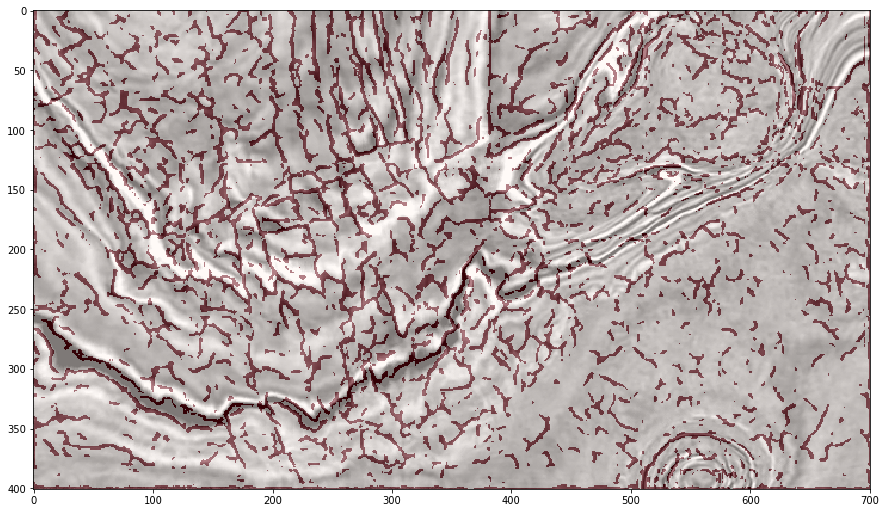

In [83]:
# visualize preds

def threshold(array, thresh):
    array[array<thresh] = 0
    array[array>=thresh]=1
    return array

plt.figure(figsize=(15,12))
plt.imshow(seismic[250].T, cmap='gray')
plt.imshow(threshold(fault_volume[250].T, 0.9), cmap='Reds', alpha=0.5)
plt.savefig('../demo/pretrained_pred.png')
plt.show()